# IMPORTS

In [0]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys

from skimage import feature
from sklearn import linear_model, metrics, model_selection
from sklearn.cluster import KMeans

# USEFUL FUNCTIONS

## Visualise landmarks

In [0]:
# Visualise face landmarks
def visualise_landmarks(img, pts, plot_lines=False):
    plt.imshow(img)
    plt.plot(pts[:, 0], pts[:, 1], '+r') # plot landmarks
    if plot_lines:
        l_eye_corner = 37 - 1
        r_eye_corner = 46 - 1
        eye_x = [pts[l_eye_corner][0], pts[r_eye_corner][0]]
        eye_y = [pts[l_eye_corner][1], pts[r_eye_corner][1]]
        plt.plot(eye_x, eye_y) # plot eyes line
       
        nose_root = 28 - 1
        nose_peak = 31 - 1
        nose_x = [pts[nose_root][0], pts[nose_peak][0]]
        nose_y = [pts[nose_root][1], pts[nose_peak][1]]
        plt.plot(nose_x, nose_y) # plot nose line
    plt.show()


# Visualise predicted vs actual landmarks
def visualise_predicted_vs_actual_landmarks(img, pred_pts, pts):
    plt.imshow(img)
    plt.plot(pts[:, 0], pts[:, 1], '+y', label='True')
    plt.plot(pred_pts[:, 0], pred_pts[:, 1], '+r', label='Predicted')
    plt.legend()
    plt.show()

## Get mean face

In [0]:
# Get the mean face from the training set landmarks
def get_mean_landmarks(pts):
    # Add x, y coords for all training landmarks
    cumpts = np.zeros(shape=(pts.shape[1], pts.shape[2]))
    for face in pts:
        for ptnum, xy in enumerate(face):
            cumpts[ptnum][0] += xy[0]
            cumpts[ptnum][1] += xy[1]

    # Average cumulated landmarks
    return cumpts / pts.shape[0]

# Visualise mean face landmarks
# blank_img = np.ones(images[0].shape)
# visualise_landmarks(blank_img, get_mean_landmarks(points))

## Save points as csv

In [0]:
def save_as_csv(points, location = '.'):
  """
  Save the points out as a .csv file
  :param points: numpy array of shape (no_image, no_points, 2) to be saved
  :param location: Directory to save results.csv in. Default to current working directory
  """
  np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')

# BENCHMARKING FUNCTIONS

## Euclidean Distance

In [0]:
def euclid_dist(pred_pts, gt_pts, measure=''):
    """
    Calculate the euclidean distance between pairs of points
    :param pred_pts: The predicted points
    :param gt_pts: The ground truth points
    :param measure: Optional. Measure applied on result (sum, mean)
    :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
    """
    pred_pts = np.reshape(pred_pts, (-1, 2))
    gt_pts = np.reshape(gt_pts, (-1, 2))
    
    euclid_dist = np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))
    
    if measure == 'sum':
        return np.sum(euclid_dist)
    elif measure == 'mean':
        return np.mean(euclid_dist)
    else:
        return euclid_dist

# Mean comparison visualisation
# for i in range(2):
#     i = np.random.randint(0, images_test.shape[0])
#     visualise_predicted_vs_actual_landmarks(images_test[i], get_mean_landmarks(points_test), points_test[i])
#     print(f'sumd err {euclid_dist(get_mean_landmarks(points_test), points_test[i], "sum")} for image {i}')
#     print(f'mean err {euclid_dist(get_mean_landmarks(points_test), points_test[i], "mean")}')

## Model versus Mean face accurracy

In [0]:
def model_vs_mean_accurracy(points_predicted, mean_face_landmarks, points_test):
    '''
    Model versus mean face accurracy
    '''
    predicted_accurracy, mean_face_accurracy = 0, 0
    for predicted_landmarks, true_landmarks in zip(points_predicted, points_test):
        predicted_accurracy += euclid_dist(predicted_landmarks, true_landmarks, 'mean')
        mean_face_accurracy += euclid_dist(mean_face_landmarks, true_landmarks, 'mean')
    
    return predicted_accurracy / points_test.shape[0], mean_face_accurracy / points_test.shape[0]

## Visualise performance

In [0]:
def plot_cumulative_density(points_test, *model_names__point_predictions):
    '''
    @param models_points_predictions: tuples ("Model name", points_predictions)
    '''
    plt.figure(figsize=(10, 5))
    for model_name, model_points_predictions in model_names__point_predictions:
        euclid_distances = []
        for predicted_landmarks, true_landmarks in zip(model_points_predictions, points_test):
            euclid_distances.append(euclid_dist(predicted_landmarks, true_landmarks, 'mean'))
            
        plt.step(np.sort(euclid_distances), np.linspace(0, 1, len(euclid_distances)), label=model_name)
    plt.xlabel('Euclidean distance between prediction and ground truth')
    plt.ylabel('Cumulative Density')
    plt.legend()

# DATA LOAD


In [8]:
# !wget "http://users.sussex.ac.uk/~is321/training_images.npz" -O data/training_images.npz
# !wget "http://users.sussex.ac.uk/~is321/test_images.npz" -O data/test_images.npz
# !wget "http://users.sussex.ac.uk/~is321/examples.npz" -O data/examples.npz

data = np.load('data/training_images.npz', allow_pickle=True)
images = data['images']
points = data['points']

examples = np.load('data/examples.npz', allow_pickle=True)
images_examples = examples['images']

data_test = np.load('data/test_images.npz', allow_pickle=True)
images_final_test = data_test['images']

images.shape, points.shape, images_examples.shape, images_final_test.shape

((2811, 250, 250, 3), (2811, 68, 2), (6, 250, 250, 3), (554, 250, 250, 3))

# DATA AUGMENTATION

## Mirror

In [0]:
def augment_mirror(images, points):
    print(f'Augmenting (mirroring) {images.shape[0]} images.', end=' ')
    mirrored_images = images[:,:,::-1,:]
    aug_images = np.concatenate((images, mirrored_images))  # Mirror images

    mirrored_points = points.copy()
    mirrored_points[:,:,0] = 250 - points[:,:,0]
    aug_points = np.concatenate((points, mirrored_points))  # Mirror points
    
    print(f'{aug_images.shape[0]} images returned.')
    return aug_images, aug_points

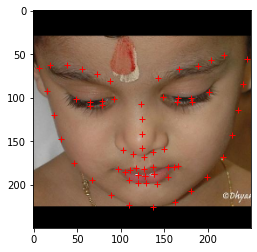

Augmenting (mirroring) 2811 images. 5622 images returned.


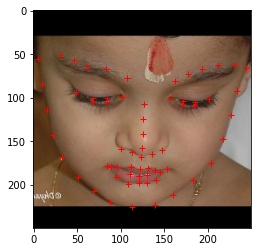

In [10]:
# NOTE: This leads to very poor results when applied to the entire data set
visualise_landmarks(images[-1], points[-1])
images, points = augment_mirror(images, points) # Mirror-augment entire data set
visualise_landmarks(images[-1], points[-1])

## [TODO] Slight rotation

# DATA PRE-PROCESS

## Remove content around face

### Vignette

In [0]:
def vignette(img): # https://stackoverflow.com/a/59053612/9993933
    rows,cols = img.shape[:2]
    zeros = np.copy(img)
    zeros[:,:,:] = 0
    a = cv.getGaussianKernel(cols, 70)
    b = cv.getGaussianKernel(rows, 70)
    c = b*a.T
    d = c/c.max()
    zeros[:,:,0] = img[:,:,0]*d
    zeros[:,:,1] = img[:,:,1]*d
    zeros[:,:,2] = img[:,:,2]*d
    return zeros

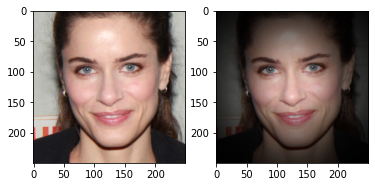

In [12]:
plt.subplot(121);   plt.imshow(images[0])
images = np.array([vignette(img) for img in images]) # Apply vignettes to entire data set
plt.subplot(122);   plt.imshow(images[0])

### Crop


In [0]:
def crop(images, points=None, off_top=0, off_btm=0, off_lef=0, off_rig=0):
    off_btm = images.shape[1] - off_btm # calculate where to stop
    off_rig = images.shape[2] - off_rig # calculate where to stop

    images = images.copy()
    images = images[:, off_top:off_btm, off_lef:off_rig, :]
    
    if points is not None:
        points = points.copy()
        points[:, :, 0] -= off_lef
        points[:, :, 1] -= off_top
        return images, points
    else:
        return images

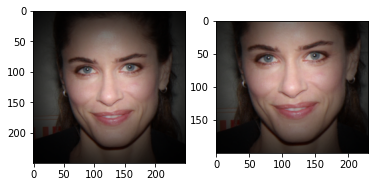

In [14]:
plt.subplot(121);   plt.imshow(images[0])
# images, points = crop(images, points, 40, 10, 10, 10) # Crop dataset, including landmarks
images = crop(images, None, 40, 10, 10, 10) # Crop dataset
plt.subplot(122);   plt.imshow(images[0])

### [WIP] Circle mask - extract outside
This was an initial idea of extracting a a circle from the centre of the image using a mask, removing all content from the edges of the image

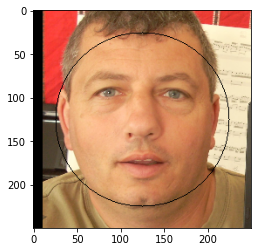

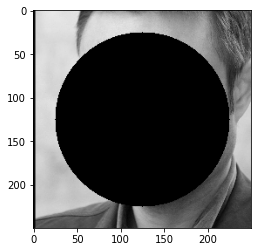

In [0]:
# DRAW CIRCLE AROUND FACE
for i in [100]:
    plt.figure()
    plt.imshow( cv.circle(images[i].copy(), (250//2, 250//2), 100, 0) )

# DRAW CIRCLE ON FACE
for i in [0]:
    plt.figure()
    plt.imshow( cv.circle(images[i].copy(), (250//2, 250//2), 100, 0, -1) )

### [WIP] Landmarks polygon mask
This was an idea of removing the content outside of the landmarks, but then I realised that test data did not have landmarks I could use.

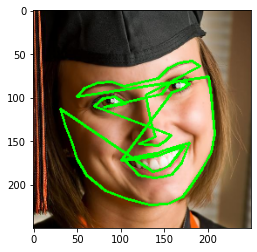

In [0]:
index = 3
pts = (points[index]).astype(np.int32).reshape((-1,1,2))

plt.imshow(
    cv.polylines(images[index].copy(), [pts], True, (0, 255, 0), 2))

## Rescaling

In [0]:
def rescale(image, landmarks=None, scale=1):
    width = int(image.shape[1] * scale)
    height = int(image.shape[0] * scale)
    if landmarks is not None:
        return cv.resize(image, (width, height)), landmarks.copy()*scale
    else:
        return cv.resize(image, (width, height))

(200, 230, 3)
(100, 115, 3)


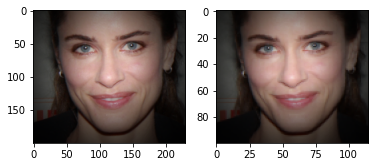

In [16]:
plt.subplot(121);   plt.imshow(images[0]); print(images[1].shape)

# Rescale entire data set
scale = .5

temp_images, temp_points = [], []
for img, pts in zip(images, points):
    # rescaled_img, rescaled_pts = rescale(img, pts, scale) # including landmarks
    rescaled_img = rescale(img, None, scale) # without landmakrs
    temp_images.append(rescaled_img)
    # temp_points.append(rescaled_pts)
# images, points = np.array(temp_images), np.array(temp_points) # including landmarks
images = np.array(temp_images) # without landmarks

plt.subplot(122);   plt.imshow(images[0]); print(images[1].shape)

In [0]:
# FOR WRITEUP
# plt.subplot(121);   plt.imshow(    vignette(images_examples[5])[40:240, 10:240]     )
# plt.subplot(122);   plt.imshow(    rescale(vignette(images_examples[5])[40:240, 10:240], None, .5)     )

## Gaussian Blur

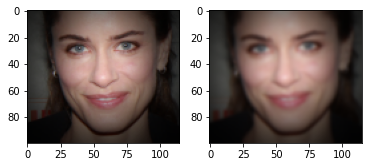

In [18]:
plt.subplot(121);   plt.imshow(images[0])
for i, img in enumerate(images):
    images[i] = cv.GaussianBlur(img, (5, 5), 1)
plt.subplot(122);   plt.imshow(images[0])

# DATA SPLIT (train/test)

In [0]:
images, images_test, points, points_test = model_selection.train_test_split(images, points, test_size=0.2, random_state=111)
images_test = np.array(images_test)
points_test = np.array(points_test)

# FEATURE EXTRACTION
This section includes many methods for feature extraction I experimented with in solving the face alignment problem

## SIFT descriptors

(array([24., 45., 32., 12.,  5.,  4.,  1.,  1.,  0.,  4.]),
 array([ 7.3333335, 16.122223 , 24.911112 , 33.7      , 42.488888 ,
        51.27778  , 60.066666 , 68.85555  , 77.64445  , 86.433334 ,
        95.22222  ], dtype=float32),
 <a list of 10 Patch objects>)

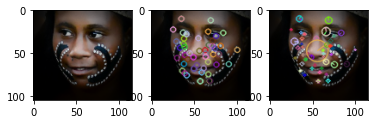

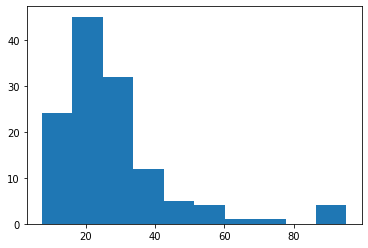

In [29]:
# SIFT Features
img = images[101].copy()

sift = cv.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(img, None)
kp_coords = np.array([keypoint.pt for keypoint in kp])

# plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(img)

temp_img = img.copy();
cv.drawKeypoints(img, kp, temp_img, flags=1)
plt.subplot(132)
plt.imshow(temp_img)

temp_img = img.copy();
cv.drawKeypoints(img, kp, temp_img, flags=4)
plt.subplot(133)
plt.imshow(temp_img)

plt.figure()
plt.hist(np.mean(des, axis=0)) # Histogram of mean of descriptors

## SURF descriptors


(array([23., 25.,  4.,  0.,  1.,  3.,  2.,  2.,  0.,  4.]),
 array([-0.0288055 ,  0.00712844,  0.04306238,  0.07899632,  0.11493026,
         0.1508642 ,  0.18679814,  0.22273207,  0.258666  ,  0.29459995,
         0.3305339 ], dtype=float32),
 <a list of 10 Patch objects>)

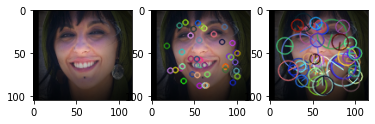

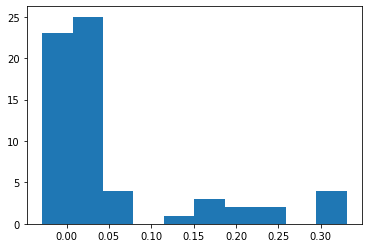

In [30]:
# SURF Features
img = images[111].copy()

sift = cv.xfeatures2d.SURF_create()
kp, des = sift.detectAndCompute(img, None)
kp_coords = np.array([keypoint.pt for keypoint in kp])

# plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(img)

temp_img = img.copy();
cv.drawKeypoints(img, kp, temp_img, flags=1)
plt.subplot(132)
plt.imshow(temp_img)

temp_img = img.copy();
cv.drawKeypoints(img, kp, temp_img, flags=4)
plt.subplot(133)
plt.imshow(temp_img)

plt.figure()
plt.hist(np.mean(des, axis=0)) # Histogram of mean of descriptors

## HOG descriptors

In [0]:
# Calculate HOG features for one image
def get_hog_descriptors(image, pixels_per_cell=(8, 8)):
    HOG_descriptors, HOG_image = feature.hog(image, orientations=8, pixels_per_cell=pixels_per_cell, visualize=True)
    HOG_image = HOG_image.astype("uint8")
    return HOG_descriptors, image, HOG_image

In [0]:
from tqdm.notebook import tqdm # Shows progress. Not necessary

# Calculate HOG features for a set of images
def calculate_hog_features(images, pixels_per_cell=(8, 8)):
    features = []
    for img in tqdm(images): # Remove tqdm() if you don't have the library installed
        hog_descriptors, _, _ = get_hog_descriptors(img, pixels_per_cell)
        features.append(hog_descriptors)

    return np.stack(features, axis=0)

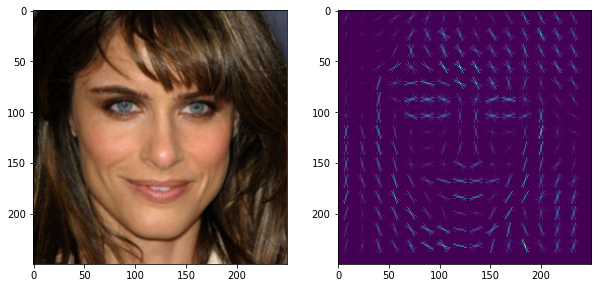

In [19]:
# Visualise hog descriptors
index = 1001

HOG_descriptors, image, HOG_image = get_hog_descriptors(images[index], (16, 16))

plt.figure(figsize=(10,10))
plt.subplot(121); plt.imshow(image) # Plot image
plt.subplot(122); plt.imshow(HOG_image)     # Plot gradients

## [N/A] Shape context descriptors
After playing around with this I realised it might be more useful in applications like character regognition or matching objects in different images.


(57,)
(57,)
0.0 0.0


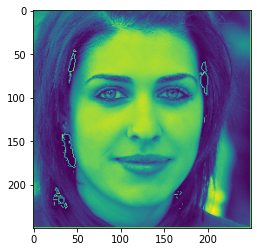

In [0]:
img = images[8].copy()
img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
_, ca, _ = cv.findContours(img, cv.RETR_CCOMP, cv.CHAIN_APPROX_TC89_KCOS) 
_, cb, _ = cv.findContours(img, cv.RETR_CCOMP, cv.CHAIN_APPROX_TC89_KCOS) 
print(np.shape(ca))
print(np.shape(cb))

hd = cv.createHausdorffDistanceExtractor()
sd = cv.createShapeContextDistanceExtractor()

d1 = hd.computeDistance(ca[0], cb[0])
d2 = sd.computeDistance(ca[0], cb[0])

cv.drawContours(img, ca, -1, (200,255,255))
plt.imshow(img)
print(d1, d2)

## Cluster training landmarks
I wanted to use these cluster centers as the starting point of a cascaded regression. However, I ended up using a single regression model.

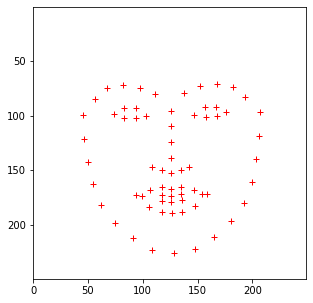

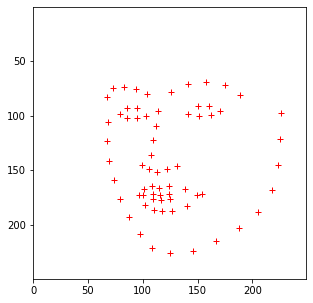

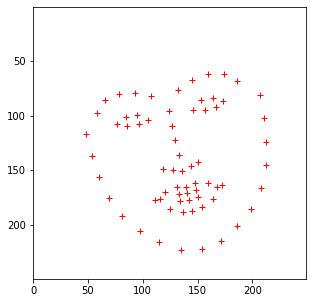

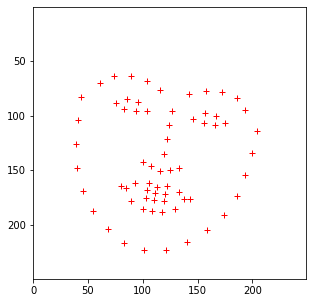

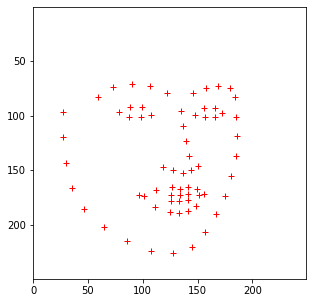

In [209]:
# Inspired by "Cascaded Face Alignment via Intimacy Definition Feature" (https://arxiv.org/pdf/1611.06642.pdf)

# K-means cluster training landmarks
n_clusters = 5

X = np.array([x.flatten() for x in points])
kmeans = KMeans(n_clusters).fit(X)

# Visualise cluster centers
for cluster_center_points in kmeans.cluster_centers_.reshape((n_clusters, points.shape[1], points.shape[2])):
    blank_img = np.ones(images[0].shape)
    visualise_landmarks(blank_img, cluster_center_points)

## Binary contours


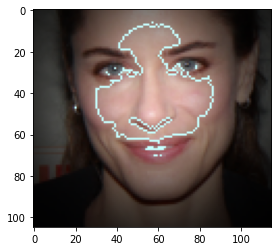

In [0]:
index = 0
img = images[index].copy()

# Binary thresholding
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(img_gray, 255//2, 255, 0)

# Contour finding
_, contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(img, contours, -1, (200,255,255))
# cv.drawContours(img, contours, -1, (200,255,255), -1) # fill

plt.imshow(img)

## Canny edge detector

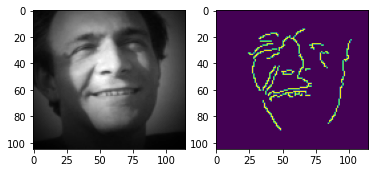

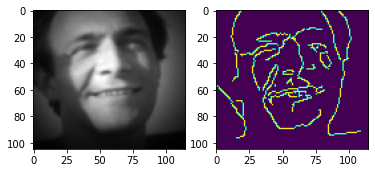

In [0]:
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html#canny
img = images[222].copy()
img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

plt.subplot(1,2,1)
plt.imshow(img_gray, cmap='gray')
plt.subplot(1,2,2)

# Run the canny edge detector with some magic numbers
im_canny = cv.Canny((img_gray), 125, 200)
plt.imshow(im_canny)
plt.show()

# Smooth the input image using the Gaussian filter as before
smooth_img = cv.GaussianBlur(img_gray, (11,11), .7)

plt.subplot(1,2,1)
plt.imshow(smooth_img, cmap='gray')
plt.subplot(1,2,2)

# Run the canny edge detector with some magic numbers
im_canny = cv.Canny(smooth_img, 50, 100)
plt.imshow(im_canny)
plt.show()

## Sobel filters

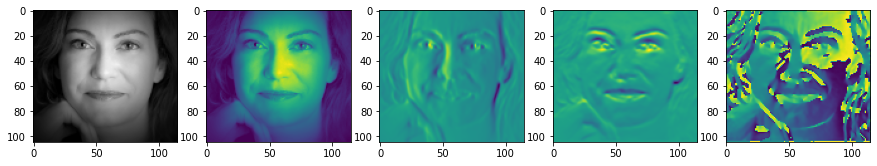

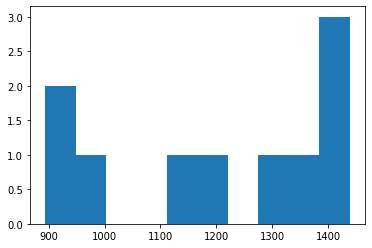

In [0]:
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_gradients/py_gradients.html#gradients
img = images[444].copy()

plt.figure(figsize=(15, 5))
plt.subplot(1,5,1)
plt.imshow(img)

img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
plt.subplot(1,5,2)
plt.imshow(img)

sobelx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=5)
plt.subplot(1,5,3)
plt.imshow(sobelx)

sobely = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=5)
plt.subplot(1,5,4)
plt.imshow(sobely)

orientation_image = np.arctan2(sobely, sobelx)
plt.subplot(1,5,5)
plt.imshow(orientation_image)
plt.show()

# Orientation histogram
plt.figure()
plt.hist(np.histogram(orientation_image, bins=10, range=(-np.pi, np.pi))[0]);

## Daisy descriptor

(180,)


(array([28., 30., 18., 28., 35., 18., 13.,  7.,  1.,  2.]),
 array([0.00422498, 0.01746449, 0.030704  , 0.04394351, 0.05718303,
        0.07042254, 0.08366205, 0.09690157, 0.11014108, 0.12338059,
        0.1366201 ]),
 <a list of 10 Patch objects>)

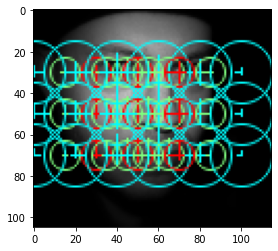

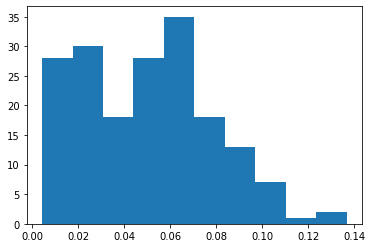

In [33]:
img = images[555].copy()
img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

descs, descs_image = feature.daisy(img, step=20, radius=30, rings=2, histograms=2, orientations=4, visualize=True)

print(descs.flatten().shape)

plt.imshow(descs_image)
plt.figure()
plt.hist(descs.flatten())

## Shape index

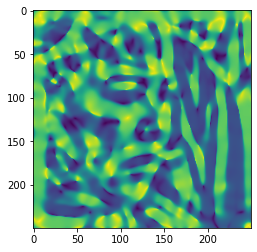

In [37]:
def calculate_shape_index_features(images):
    features = []
    for img in tqdm(images.copy()):
        img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        feature_shape = feature.shape_index(img, sigma=5)

        features.append(feature_shape.flatten())
    
    return np.stack(features, axis=0)

index = 30

img = images[index].copy()
pts = points[index].copy()

img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
feature_shape = feature.shape_index(img, sigma=5)

plt.imshow(feature_shape)

# REGRESSION

## Simple Linear Regression - using (summed coordinates of) SIFT features
This was my first (hilarious) attempt at solving the problem using univariate linear regression. Just the idea of predicting 68 landmark coordinates using one number is beautifully idiotic.

In [212]:
from tqdm.notebook import tqdm # Shows progress. Not necessary

sift = cv.xfeatures2d.SIFT_create()

X = []
for img in tqdm(images): # Remove tqdm if you don't have it intalled.    
    kp, des = sift.detectAndCompute(img, None)
    kp_coords = np.array([keypoint.pt for keypoint in kp])
    kp_coords_sum = np.sum(kp_coords, axis=0)
    X.append(kp_coords_sum)

X = np.array(X)

y = np.array([pts.flatten() for pts in points])

X.shape, y.shape

((2811, 2), (2811, 136))

In [0]:
# Regression
simple_reg = linear_model.LinearRegression().fit(X, y)

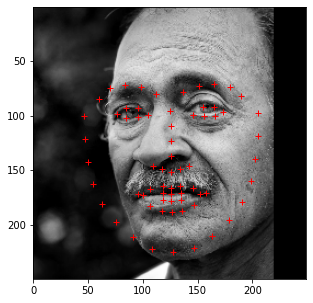

sumd err 724.3355053535824 for test image 456
mean err 10.651992725787977


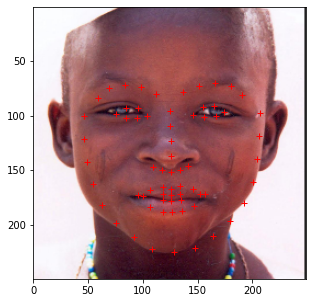

sumd err 580.4916587509789 for test image 177
mean err 8.536642040455572


In [235]:
# Run some examples
for i in range(2):
    i = np.random.randint(0, images_test.shape[0])
    img = images_test[i].copy()

    # Get SIFT keypoints and the sum of their coordinates
    sift = cv.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    kp_coords = np.array([keypoint.pt for keypoint in kp])
    kp_coords_sum = np.sum(kp_coords, axis=0)

    # Predict landmark points using the sum of coordinates of SIFT keypoints
    predicted_pts = simple_reg.predict([kp_coords_sum]).reshape(points_test[0, ...].shape)
    actual_pts    = points_test[i]

    # visualise_predicted_vs_actual_landmarks(img, actual_pts, predicted_pts)
    visualise_landmarks(img, predicted_pts)
    print(f'sumd err {euclid_dist(predicted_pts, actual_pts, "sum")} for test image {i}')
    print(f'mean err {euclid_dist(predicted_pts, actual_pts, "mean")}')

In [0]:
# NOTE: This was one of the early ideas I had, to use certain landmarks at different stages of the cascaded regression

# Choose only certain landmarks for training
# visualise_landmarks(images[10], points[:,27:48,:][10])
# visualise_landmarks(images[10], points[:,27:36,:][10])
# visualise_landmarks(images[10], points[:,36:,:][10]) # Mouth and eyes - Lower mean, but mean face, too
# visualise_landmarks(images[10], points[:,27:31,:][10]) # Nose line - Didn't do particularly well
# points = points[:,36:,:]

## Multivariate Linear Regression - HOG descriptors -> Landmarks

In [13]:
# Create training X and Y
train_X_features = calculate_hog_features(images)
train_Y_landmrks = np.array([coords.flatten() for coords in points])

In [0]:
# Fit multivariate linear regression model
reg = linear_model.LinearRegression().fit(train_X_features, train_Y_landmrks)

In [17]:
# Create test X and predict Y
test_X_features  = calculate_hog_features(images_test)
test_Y_predictions = reg.predict(test_X_features).reshape(points_test.shape[0], points_test.shape[1], points_test.shape[2])

points_predicted__multivariate_regression = test_Y_predictions

## Analyse model predictions


In [18]:
model_vs_mean_accurracy(points_predicted__multivariate_regression, get_mean_landmarks(points), points_test)

(4.225767390398718e-14, 11.46955906411595)

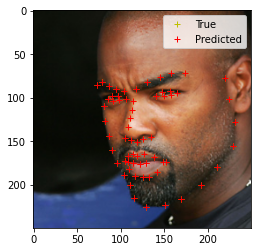

sumd err 2.1656551602705814e-12 for test image 248
mean err 3.184787000397914e-14


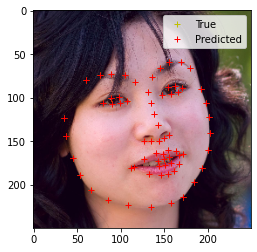

sumd err 3.016030497466701e-12 for test image 158
mean err 4.4353389668627955e-14


In [19]:
# Visualise some predictions
for i in range(2):
    i = np.random.randint(0, images_test.shape[0])
    visualise_predicted_vs_actual_landmarks(images_test[i], test_Y_predictions[i], points_test[i])
    print(f'sumd err {euclid_dist(test_Y_predictions[i], points_test[i], "sum")} for test image {i}')
    print(f'mean err {euclid_dist(test_Y_predictions[i], points_test[i], "mean")}')

## Compare models

### Save and load models


In [0]:
# save model to disk
pickle.dump(reg, open(filename, 'wb'))  

In [0]:
# Model A (49.270942001091555, 34.11563616822246)
filename_A = 'models/A__mirror_vignette_crop40-10-10-10_rescale50_gaussblr5-5-1_HOG8-8-8.sav'

# Model B (8.537364856711964, 11.46955906411595)
filename_B = 'models/B__vignette_crop40-10-10-10_rescale50_gaussblr5-5-1_HOG8-8-8.sav'

# Model C (6.945037005723391, 11.46955906411595)

# Model D (5.837413368171335, 11.46955906411595)
filename_D = 'models/D__HOG8-8-8.sav'

# Model E (6.022420059777884, 11.46955906411595)
filename_E = 'models/E__vignette_HOG8-8-8.sav'

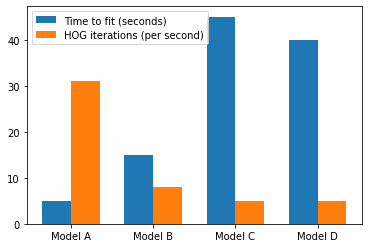

In [69]:
labels = ['Model A', 'Model B', 'Model C', 'Model D']
Delta_model_fit_seconds = [5, 15, 45, 40]
HOG_iterations_per_second = [31, 8, 5, 5]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Delta_model_fit_seconds, width, label='Time to fit (seconds)')
rects2 = ax.bar(x + width/2, HOG_iterations_per_second, width, label='HOG iterations (per second)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

In [0]:
# load the model from disk
loaded_model_A = pickle.load(open(filename_A, 'rb'))
loaded_model_B = pickle.load(open(filename_B, 'rb'))
loaded_model_C = pickle.load(open(filename_C, 'rb'))
loaded_model_D = pickle.load(open(filename_D, 'rb'))
loaded_model_E = pickle.load(open(filename_E, 'rb'))

In [31]:
# Pre-process example images the same way as the training data was
images_ABC = images_test.copy()
images_ABC = np.array([vignette(img) for img in images_ABC])
images_ABC = crop(images_ABC, None, 40, 10, 10, 10)
images_ABC = np.array([rescale(img, None, .5) for img in images_ABC])
images_ABC = np.array([cv.GaussianBlur(img, (5, 5), 1) for img in images_ABC])
images_A, points_A = augment_mirror(images_ABC, points_test)

Augmenting (mirroring) 563 images. 1126 images returned.


In [0]:
# Get test data features
X_A = calculate_hog_features(images_A,   (8, 8))
X_B = calculate_hog_features(images_ABC, (8, 8))
X_C = calculate_hog_features(images_ABC, (4, 4))
X_D = calculate_hog_features(images_test,(8, 8))

In [0]:
# Predict landmarks for test data
Y_A = loaded_model_A.predict(X_A).reshape(points_A.shape[0], points_A.shape[1], points_A.shape[2])
Y_B = loaded_model_B.predict(X_B).reshape(points_test.shape[0], points_test.shape[1], points_test.shape[2])
Y_C = loaded_model_C.predict(X_C).reshape(points_test.shape[0], points_test.shape[1], points_test.shape[2])
Y_D = loaded_model_D.predict(X_D).reshape(points_test.shape[0], points_test.shape[1], points_test.shape[2])

### Visualise comparison

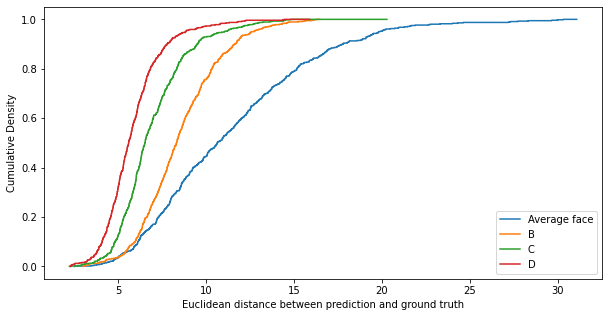

In [242]:
plot_cumulative_density(
    points_test,
    ('Average face', [get_mean_landmarks(points)] * points_test.shape[0]),
    # ('A', Y_A),
    ('B', Y_B),
    ('C', Y_C),
    ('D', Y_D))

# SEGMENTATION

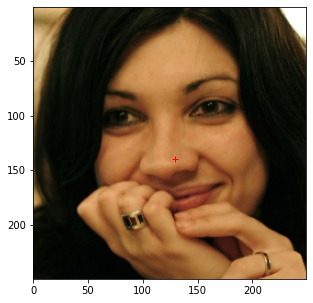

array([[129., 140.]])

In [247]:
# Calculate center of gravity
def get_centroid(points):
    x_sum = 0
    y_sum = 0
    for coords in points:
        x_sum += coords[0]
        y_sum += coords[1]
    coords = np.array((x_sum//points.shape[0], y_sum//points.shape[0]))
    return np.array([coords])

index = 151
# visualise_landmarks(images[index], points[index])
visualise_landmarks(images[index], get_centroid(points[index]))
get_centroid(points[index])

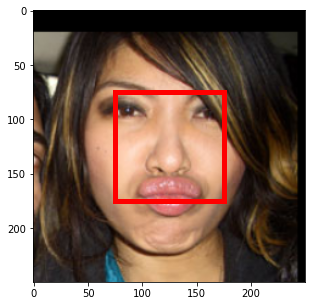

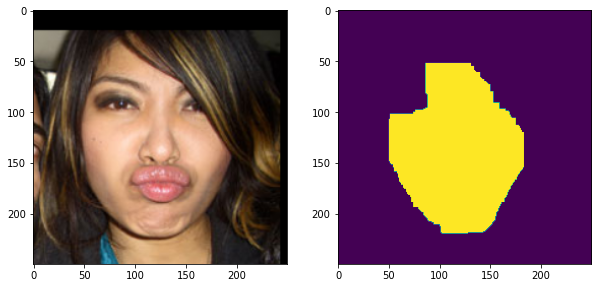

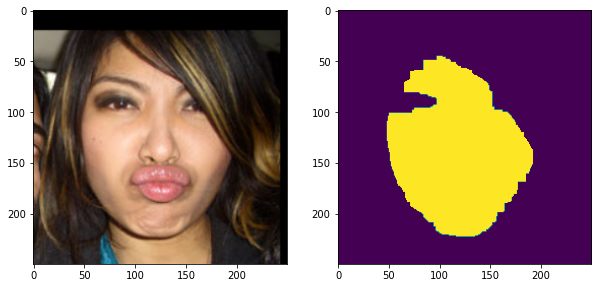

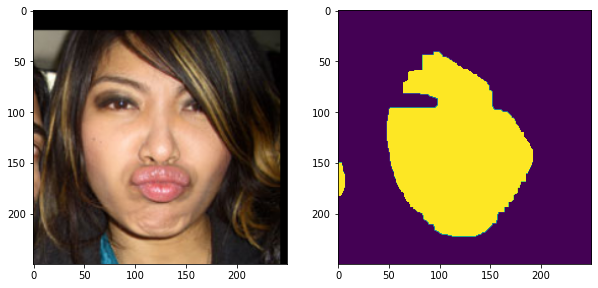

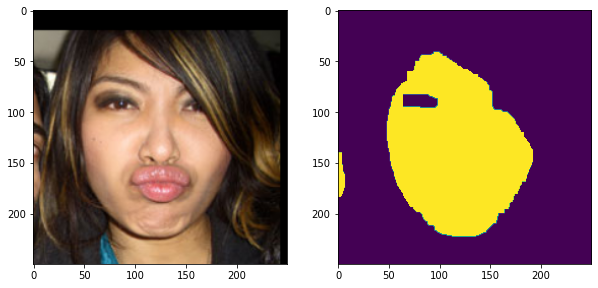

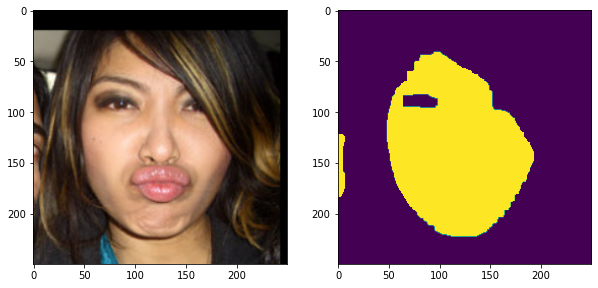

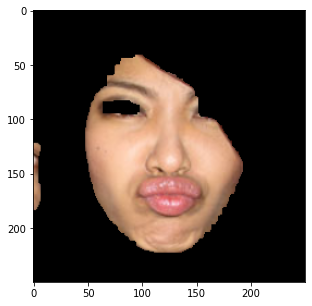

In [250]:
def create_initial_fg_mask(_img):
  from matplotlib import patches
  # Let's create a binary image for the inital foreground mask
  fg_mask = np.zeros(_img.shape[0:2], dtype=np.bool)

  # A simple assumption about the object of interest is that it's in the centre of the
  # image and pix_around_center *2 pixels wide will give us a good starting set of pixels
  pix_around_center = 50
  fg_mask[_img.shape[0] // 2 - pix_around_center: _img.shape[0] // 2 +pix_around_center, _img.shape[1] // 2 - pix_around_center: _img.shape[1] // 2 +pix_around_center] = True

  # Draw some stuff!
  ax = plt.subplot(111)
  plt.imshow(_img)
  # Draw a rectangle of the box we're using for the initial foreground
  rect = patches.Rectangle((_img.shape[1] // 2 -pix_around_center, _img.shape[0]//2 - pix_around_center), pix_around_center*2, pix_around_center*2, fill=False, lw=5, color='r')
  ax.add_patch(rect)
  plt.show()
  return fg_mask

def grabcut(_img):
  import maxflow
  from sklearn.mixture import GaussianMixture
  plt.rcParams['figure.figsize'] = [10, 5]

  flat = np.reshape(_img, (-1, 3))
  # Create a mixture of Gaussians model to describe the colours of the foreground object
  fg_gmm = GaussianMixture(3)
  # Create a mixture of Gaussians model to describe the colours of the background object
  bg_gmm = GaussianMixture(5)

  fg_mask = create_initial_fg_mask(_img)
  # The initial background mask is the inverse of the foreground
  bg_mask = fg_mask == False

  # The smoothness weight is really important! Make it bigger to encourage
  # nearby pixels to have the same label
  smoothness_weight = 10
  for i in range(5):
    fg_gmm.fit(np.reshape(_img[fg_mask], (-1, 3)))
    bg_gmm.fit(np.reshape(_img[bg_mask], (-1, 3)))


    fg_lp = np.reshape(fg_gmm.score_samples(flat), _img.shape[0:2])
    bg_lp = np.reshape(bg_gmm.score_samples(flat), _img.shape[0:2])

    # The following lines are just setting up the GraphCut operation, which
    # Tries to ensure the labelling is smooth.
    g = maxflow.Graph[float](0, 0)
    nodeids = g.add_grid_nodes(_img.shape[0:2])
    # We need to add a weight for the smoothness term here
    g.add_grid_edges(nodeids, smoothness_weight)
    # We need to add the log probability of a pixel being foreground or background here
    g.add_grid_tedges(nodeids, -fg_lp, -bg_lp)
    g.maxflow()
    # Get the labelling from the maxflow/mincut
    sgm = g.get_grid_segments(nodeids)

    # Reassign the fg_mask based on our new estimate
    fg_mask = sgm
    bg_mask = sgm == False

    # Draw some stuff!
    plt.subplot(121)
    plt.imshow(_img)
    plt.subplot(122)
    plt.imshow(sgm*1)
    plt.show()

  return fg_mask


index = 515
fg_mask = grabcut(images[index])
plt.imshow(np.expand_dims(fg_mask, axis=-1)*images[index])
plt.show()

# Idea: Apply CLOSE morph operator
# Idea: Cut everything out of the landmarks
# Idea

# FACE FILTER

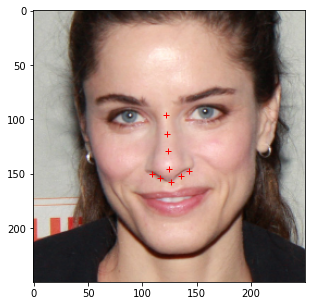

In [0]:
# Get nose coordinates
visualise_landmarks(images[0], points[0][27:36])

In [0]:
from math import hypot

def clown_nose(img, pts):
    '''
    inspired from https://pysource.com/2019/03/25/pigs-nose-instagram-face-filter-opencv-with-python/
    '''

    # Loading Nose image and Creating mask
    nose_image = cv.imread("nose.png")
    nose_image = cv.cvtColor(nose_image, cv.COLOR_BGR2RGB)

    rows, cols, _ = img.shape
    nose_mask = np.zeros((rows, cols), np.uint8)

    nose_mask.fill(0)

    # Nose coordinates
    top_nose    = (pts[29][0], pts[29][1])
    center_nose = (pts[30][0], pts[30][1])
    left_nose   = (pts[31][0], pts[31][1])
    right_nose  = (pts[35][0], pts[35][1])

    # Nose size
    nose_width = int(hypot(left_nose[0] - right_nose[0],
                           left_nose[1] - right_nose[1]) * 1.75)
    nose_height = int(nose_width * 1)

    # New nose position
    top_left = (int(center_nose[0] - nose_width / 2), 
                int(center_nose[1] - nose_height / 2))
    bottom_right = (int(center_nose[0] + nose_width / 2), 
                    int(center_nose[1] + nose_height / 2))

    # Adding the new nose
    nose_clown = cv.resize(nose_image, (nose_width, nose_height))
    nose_clown_gray = cv.cvtColor(nose_clown, cv.COLOR_BGR2GRAY)
    _, nose_mask = cv.threshold(nose_clown_gray, 15, 255, cv.THRESH_BINARY_INV)

    nose_area = img[top_left[1]: top_left[1] + nose_height,
                    top_left[0]: top_left[0] + nose_width]

    nose_area_no_nose = cv.bitwise_and(nose_area, nose_area, mask=nose_mask)

    final_nose = cv.add(nose_area_no_nose, nose_clown)

    img[top_left[1]: top_left[1] + nose_height,
                top_left[0]: top_left[0] + nose_width] = final_nose

    plt.figure()
    plt.imshow(img)

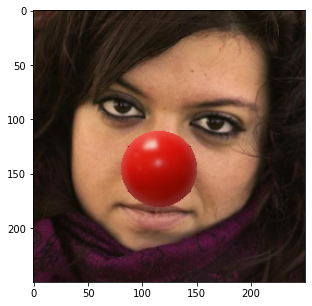

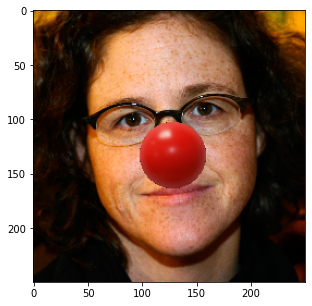

In [256]:
# Get landmark predictions for the example images
X_D_examples = calculate_hog_features(images_examples, (8, 8))
Y_D_examples = loaded_model_D.predict(X_D_examples).reshape(6, points_test.shape[1], points_test.shape[2])

for i in [1, 5]:
    clown_nose(images_examples[i].copy(), Y_D_examples[i].copy())

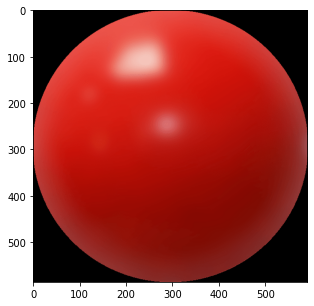

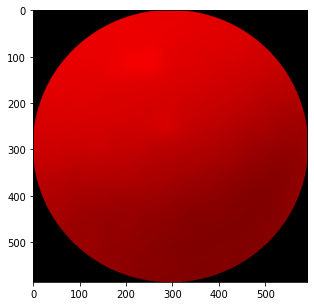

In [257]:
# WIP - Try to bring the nose to the same contrast and brightness as the image
nose_image = cv.imread("nose.png")
nose_image = cv.cvtColor(nose_image, cv.COLOR_BGR2RGB)
plt.figure()
plt.imshow(nose_image)


alpha=1
beta=0

res = cv.multiply(nose_image, alpha)
res = cv.add(res, beta)

plt.figure()
plt.imshow(res)

# TEST PREDICTIONS

In [0]:
X_D_final_test = calculate_hog_features(images_final_test, (8, 8))
Y_D_final_test = loaded_model_D.predict(X_D_final_test).reshape(images_final_test.shape[0], points_test.shape[1], points_test.shape[2])

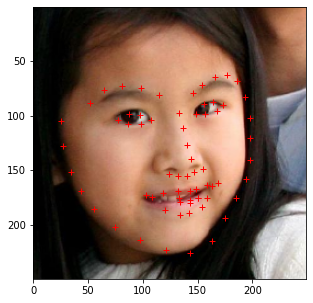

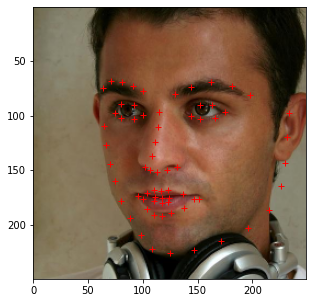

In [208]:
# Visualise some predictions
for i in range(2):
    i = np.random.randint(0, images_final_test.shape[0])
    visualise_landmarks(images_final_test[i], Y_D_final_test[i])

In [0]:
save_as_csv(Y_D_final_test)

# USEFUL LINKS
## Image segmentation
- https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html#watershed

## Face detection
- https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html